<a href="https://colab.research.google.com/github/orpatashnik/StyleCLIP/blob/main/StyleCLIP_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery

In [ ]:
#@title Setup (may take a few minutes)
%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 
! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/orpatashnik/StyleCLIP 

# Select dataset 
If you want to use another dataset, please restart runtime. currently, we only support ffhq.

In [ ]:
dataset_name='ffhq' #@param ['ffhq'] {allow-input: true}
# input dataset name 

% cd /content/StyleCLIP/global/

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

# choose image index
 

In [12]:

img_index = 1 #@param {type:"number"}
img_indexs=[img_index]
dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

# input text description 
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |


In [14]:
neutral='face with hair' #@param {type:"string"}
target='face with grey hair' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.3967


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

num of channels being manipulated: 21


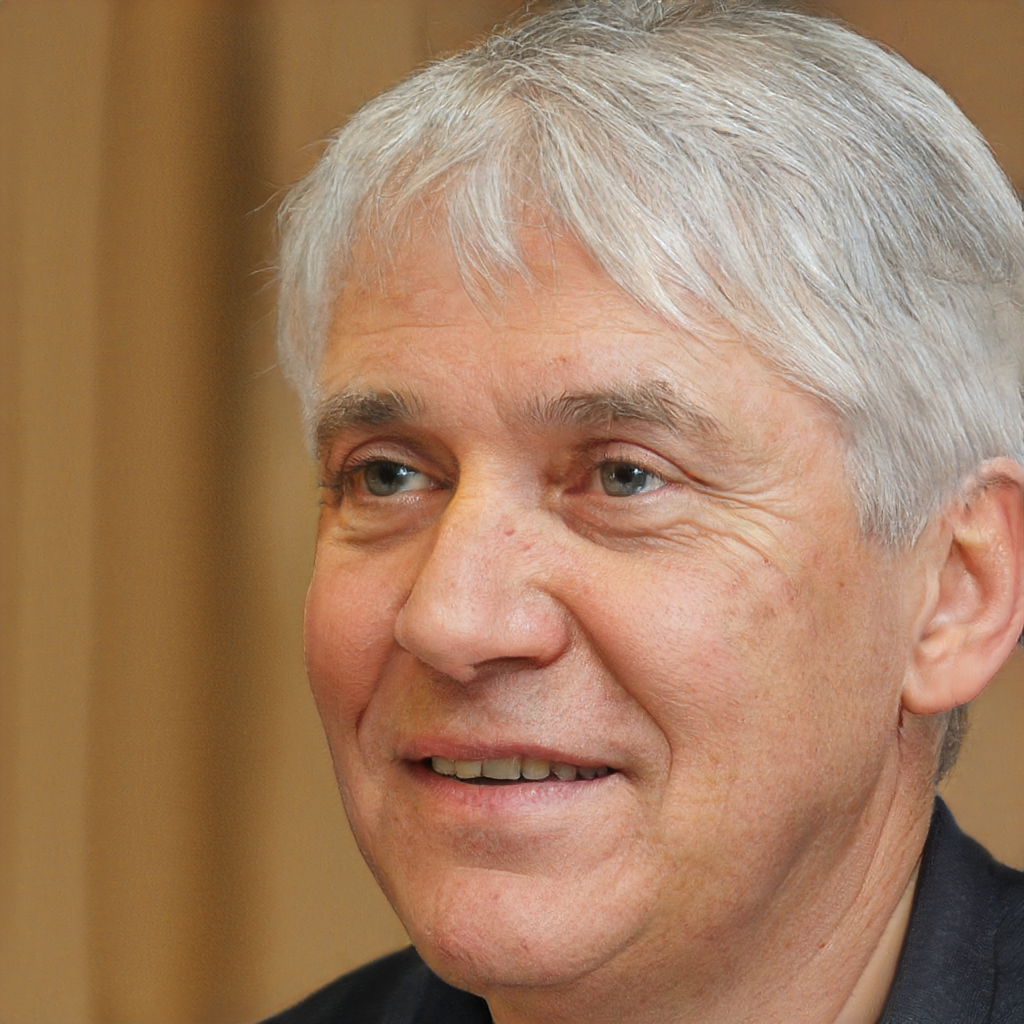

In [16]:
#beta=0.1
#alpha=1
beta = 0.15 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 5.1 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
Image.fromarray(out[0,0])